In [22]:
import numpy as np
import matplotlib.pyplot as plt

### Problem #1
Certain types of near-fault ground motion can be represented by a full cosine cycle of ground acceleration.
For example, consider the following ground motion (similar equation as HW#5):

\begin{align}
    \ddot{u}_g(t) = 
    \begin{cases}
        8 \sin{(\pi t)/0.4} ~\text{ft/s}^2 & \text{for}~ 0\leq t \leq 1.1~\text{sec} \\
        0  & \text{for}~ 0\leq t \leq 1.2~\text{sec}
    \end{cases}
\end{align}

Assuming that the ground velocity and displacement are both zero at time zero, use the constant average
acceleration method to numerically determine the pseudo-acceleration response spectrum for $\zeta = 0.05$. Use an
appropriate time step and resolution of the natural period, $T_n$. Plot the spectrum against $T_n$.

In [23]:
# Let's pull our constant average acceleration method from last HW:

def newmark_beta(m, k, c, uo, udot0, dt, p, beta=1/4, gamma=1/2):
    '''
    Newmark-beta method for solving the equation of motion of a single degree of freedom system.
    Parameters:
        m : mass
        k : stiffness
        c : damping coefficient
        uo : initial displacement
        udot0 : initial velocity
        dt : time step
        p : external force array (given as np array or list)
        beta : Newmark-beta parameter (default is 1/4)
        gamma : Newmark-gamma parameter (default is 1/2)
    Returns:
        u : displacement array
        v : velocity array
        a : acceleration array
    '''
    n = len(p)  # number of time steps
    u = np.zeros(n)  # displacement array
    v = np.zeros(n)  # velocity array
    a = np.zeros(n)  # acceleration array
    u[0] = uo
    v[0] = udot0

    # Initial acceleration
    a[0] = (p[0] - c * v[0] - k * u[0]) / m

    # Newmark-beta effective coefficients (Chopra Eq. 16.5.6, 16.5.7)
    a0 = 1.0 / (beta * dt ** 2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2 * beta) - 1
    a4 = gamma / beta - 1
    a5 = dt * (gamma / (2 * beta) - 1)

    k_hat = k + a0 * m + a1 * c

    # Time-stepping loop
    for i in range(1, n):
        # Effective force (Chopra Eq. 16.5.8)
        p_hat = p[i] + m * (a0 * u[i - 1] + a2 * v[i - 1] + a3 * a[i - 1]) \
                      + c * (a1 * u[i - 1] + a4 * v[i - 1] + a5 * a[i - 1])
        u[i] = p_hat / k_hat
        a[i] = a0 * (u[i] - u[i - 1]) - a2 * v[i - 1] - a3 * a[i - 1]
        v[i] = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a[i])

    # print("Newmark-Beta Method Completed")

    return u, v, a

In [24]:
# Now, let's create a loop to generate the response spectrum

m = 1.0  # mass
zeta = 0.05  # damping ratio
g = 32.2  # gravitational acceleration in ft/s^2

A = []  # to store pseudo-acceleration
Tn_vec = np.linspace(0.01, 4, 500)  # natural periods

for Tn in Tn_vec:
    wn = 2 * np.pi / Tn  # natural frequency
    k = m * wn ** 2  # stiffness
    c = 2 * m * wn * zeta  # damping coefficient

    # Define time parameters
    dt = min(0.01, Tn / 20)  # time step (picking an appropriate dt for each Tn)

    t = np.arange(0, 5, dt)  # time array (up to 5 seconds)
    ug_ddot = 8.0 * np.sin(2 * np.pi / 0.4 * t)  # ground acceleration (given) ft/s^2
    p = -m * ug_ddot  # effective force

    u, v, a = newmark_beta(m, k, c, 0, 0, dt, p)

    U = np.max(np.abs(u))  # maximum absolute displacement
    A.append(wn**2 * U / g)  # pseudo-acceleration (Chopra Eq. 16.5.1)

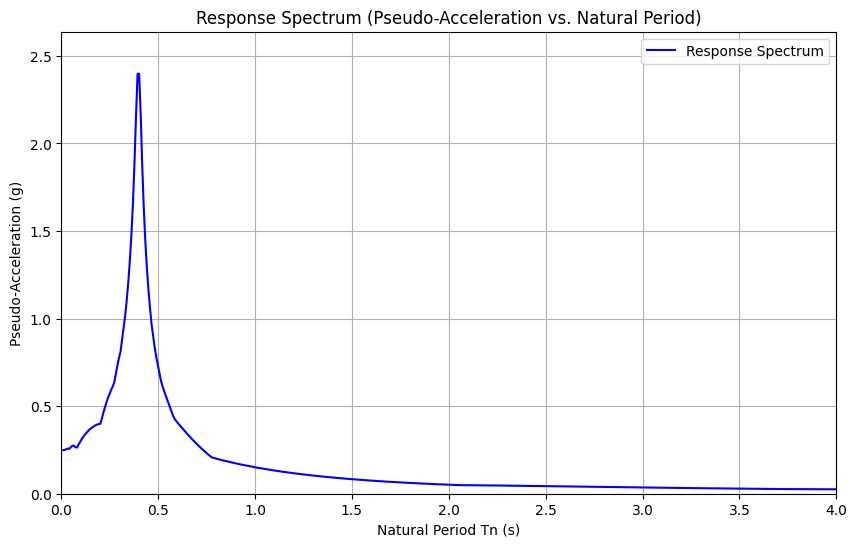

In [25]:
# Plotting the response spectrum

plt.figure(figsize=(10, 6))
plt.plot(Tn_vec, A, label='Response Spectrum', color='blue')
plt.title('Response Spectrum (Pseudo-Acceleration vs. Natural Period)')
plt.xlabel('Natural Period Tn (s)')
plt.ylabel('Pseudo-Acceleration (g)')
plt.grid()
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, max(A)*1.1)
plt.show()

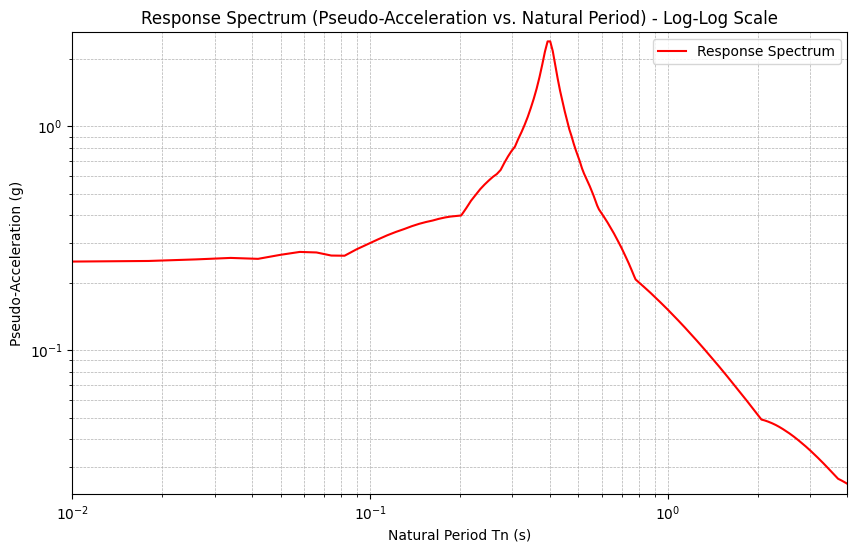

In [26]:
# In log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(Tn_vec, A, label='Response Spectrum', color='red')
plt.title('Response Spectrum (Pseudo-Acceleration vs. Natural Period) - Log-Log Scale')
plt.xlabel('Natural Period Tn (s)')
plt.ylabel('Pseudo-Acceleration (g)')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlim(0.01, 4)
plt.ylim(min(A)*0.9, max(A)*1.1)
plt.show()  